In [504]:
import sys
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_info_rows = None
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_predict
from sklearn.multioutput import MultiOutputRegressor

In [925]:
con = pd.read_csv("data/R_download/2014 - conditions.csv")
hh = pd.read_csv("data/R_download/2014 - hh.csv")
inpatient = pd.read_csv("data/R_download/2014 - inpatient.csv")
office = pd.read_csv("data/R_download/2014 - office.csv")
outpatient = pd.read_csv("data/R_download/2014 - outpatient.csv")
rx = pd.read_csv('data/R_download/2014 - rx.csv')
er = pd.read_csv('data/R_download/2014 - er.csv')

In [ ]:
#insurance status of patient inscov14 -- population characteristics file 

Population Characteristics

In [405]:
#mood_exp = pd.concat([mood_disorder_single_duper, mood_inpatient_total, 
#                                 mood_off_total, mood_outpat_total, mood_rx_total], axis =1)
#mood_exp.info(null_counts=True)

In [517]:
#DUPERSIDS don't match 
pop = pd.read_csv("data/R_download/2014 - popchar.csv")

In [599]:
pop_df['VARPSU'].value_counts()

2    17016
1    15206
3     2653
Name: VARPSU, dtype: int64

In [607]:
#age, sex, race
pop_df = pop.filter(["DUPERSID", "SEX","AGE14X","RACEV1X", "INSCOV14", "PERWT14P", "VARPSU",
                    "VARSTR","MARRY14X","EDRECODE","REGION14"], 1)
pop_df.set_index("DUPERSID", inplace = True)
#print pop_df.shape, pop_df.info()


#SEX: male = 1, female = 2
#pop['SEX'].value_counts()
pop_dummy_sex = pd.get_dummies(pop_df['SEX'])
pop_dummy_sex.columns = list(['male', 'female'])
#print pop_dummy_sex['male'].sum()

pop_dummy_race = pd.get_dummies(pop_df['RACEV1X'])
pop_dummy_race.columns = list(["white",'black', 'native_amer', 'asian', 'multiple_races'])

pop_dummy_insur = pd.get_dummies(pop_df["INSCOV14"])
pop_dummy_insur.columns = list(["any_private_ins", 'public_only_ins', "uninsured"])

pop_dummy_marital = pd.get_dummies(pop_df["MARRY14X"])
pop_dummy_marital.columns = list(["NA_married", "DK_married", "refused_married", "married","widowed", 'divorced', "separated", "never_married","under_16"])

#print pop_dummy_marital['NA'].sum(), pop_dummy_marital['DK'].sum(), pop_dummy_marital['married'].sum()
pop_dummy_education = pd.get_dummies(pop_df["EDRECODE"])
pop_dummy_education.columns = list(["NA_edu", "DK_edu", "refused_edu", "inapp_or_under_5_edu", "8th_grade_edu",
                                    "some_high_school", "hs_grad", "assoc_deg", "bach_deg",
                                   "master_deg"])
pop_dummy_region = pd.get_dummies(pop_df["REGION14"])
pop_dummy_region.columns = list(["inapp","northeast","midwest","south", "west"])

pop_df_no_dummies = pop_df.drop(["SEX","RACEV1X", "INSCOV14", "MARRY14X", "EDRECODE",
                                 "REGION14", "VARPSU", "PERWT14P", "VARSTR"], 1)
pop_df_w_dummies = pd.concat([pop_df_no_dummies, pop_dummy_sex, pop_dummy_race, pop_dummy_insur, pop_dummy_marital, 
                                 pop_dummy_education, pop_dummy_region], axis =1)

#print pop_df_w_dummies.shape, pop_df_w_dummies.head()

In [527]:
#Make adult column, depr column? heart column?
#no poverty categories...
#Charleston comorbidity index excluding diagnosis of interest
#medicine is the number of prescribed medicines including refills in 2012.
#Othercosts?
#Metropolitan statistical area only on 2012 and maybe less recent groups

Outpatient Filtration

In [843]:
mood_outpat = outpatient[outpatient["OPCCC1X"] == 657]
mood_outpat_2 = outpatient[outpatient["OPCCC2X"] == 657]
mood_outpat_3 = outpatient[outpatient["OPCCC3X"] == 657]
mood_outpat_4 = outpatient[outpatient["OPCCC4X"] == 657]

mood_outpat.head()
mood_outpat_total = mood_outpat.append([mood_outpat_2, mood_outpat_3,mood_outpat_4])
mood_outpat_total.head()

#total expenditure for event: facility plus doctor
mood_outpat_total = mood_outpat_total.filter(["DUPERSID", "OPXP14X"], 1)
mood_outpat_total = mood_outpat_total.groupby('DUPERSID').sum()
mood_outpat_total.head()

not_mood_outpat = outpatient[outpatient["OPCCC1X"] != 657]
not_mood_outpat_2 = outpatient[outpatient["OPCCC2X"] != 657]
not_mood_outpat_3 = outpatient[outpatient["OPCCC3X"] != 657]
not_mood_outpat_4 = outpatient[outpatient["OPCCC4X"] != 657]

not_mood_outpat.head()
not_mood_outpat_total = not_mood_outpat.append([not_mood_outpat_2, not_mood_outpat_3,not_mood_outpat_4])
not_mood_outpat_total.head()

#total expenditure for event: facility plus doctor
not_mood_outpat_total = not_mood_outpat_total.filter(["DUPERSID", "OPXP14X"], 1)
not_mood_outpat_total = not_mood_outpat_total.groupby('DUPERSID').sum()
not_mood_outpat_total.head()

,OPXP14X
DUPERSID,
40001102,1609.04
40014101,5771.60
40014103,4504.08
40015102,1480.00
40022101,1509.84


Office filtration

In [845]:
mood_off = office[office["OBCCC1X"] == 657]
mood_off_2 = office[office["OBCCC2X"] == 657]
mood_off_3 = office[office["OBCCC3X"] == 657]
mood_off_4 = office[office["OBCCC4X"] == 657]

mood_off.head()
mood_off_total = mood_off.append([mood_off_2, mood_off_3,mood_off_4])
mood_off_total.head()

#sum of the 12 sources of payment for the office-based expenditures
mood_off_total = mood_off_total.filter(["DUPERSID", "OBXP14X"], 1)
mood_off_total = mood_off_total.groupby('DUPERSID').sum()
mood_off_total.head()

not_mood_off = office[office["OBCCC1X"] != 657]
not_mood_off_2 = office[office["OBCCC2X"] != 657]
not_mood_off_3 = office[office["OBCCC3X"] != 657]
not_mood_off_4 = office[office["OBCCC4X"] != 657]

not_mood_off.head()
not_mood_off_total = not_mood_off.append([not_mood_off_2, not_mood_off_3,not_mood_off_4])
not_mood_off_total.head()

#sum of the 12 sources of payment for the office-based expenditures
not_mood_off_total = not_mood_off_total.filter(["DUPERSID", "OBXP14X"], 1)
not_mood_off_total = not_mood_off_total.groupby('DUPERSID').sum()
not_mood_off_total.head()

,OBXP14X
DUPERSID,
40001101,3048.24
40001102,1100.24
40001103,463.64
40001104,368.00
40002101,331.88


RX filtration

In [846]:
#use inpatient 
mood_rx = rx[rx["RXCCC1X"] == 657]
mood_rx_2 = rx[rx["RXCCC2X"] == 657]
mood_rx_3 = rx[rx["RXCCC3X"] == 657]
mood_rx.head()
#mood_rx["DUPERSID"].value_counts()
#mood_rx.head(100)
mood_rx_total = mood_rx.append([mood_rx_2, mood_rx_3])
mood_rx_total.head()
#Sum of payments
mood_rx_total = mood_rx_total.filter(["DUPERSID", "RXXP14X"], 1)
mood_rx_total = mood_rx_total.groupby('DUPERSID').sum()
mood_rx_total.head()


#use inpatient 
not_mood_rx = rx[rx["RXCCC1X"] != 657]
not_mood_rx_2 = rx[rx["RXCCC2X"] != 657]
not_mood_rx_3 = rx[rx["RXCCC3X"] != 657]
mood_rx.head()
#mood_rx["DUPERSID"].value_counts()
#mood_rx.head(100)
not_mood_rx_total = not_mood_rx.append([not_mood_rx_2, not_mood_rx_3])
not_mood_rx_total.head()
#Sum of payments
not_mood_rx_total = not_mood_rx_total.filter(["DUPERSID", "RXXP14X"], 1)
not_mood_rx_total = not_mood_rx_total.groupby('DUPERSID').sum()
not_mood_rx_total.head()

,RXXP14X
DUPERSID,
40001101,1902.81
40001102,1304.22
40002101,7.47
40004102,36.00
40004103,238.50


Emergency Room

In [932]:
mood_er = er[er["ERCCC1X"] == 657]
mood_er_2 = er[er["ERCCC2X"] == 657]
mood_er_3 = er[er["ERCCC3X"] == 657]
mood_er_4 = er[er["ERCCC4X"] == 657]

mood_er.head()
mood_er_total = mood_er.append([mood_er_2, mood_er_3,mood_er_4])
mood_er_total.head()

#sum of the 12 sources of payment for the office-based expenditures
mood_er_total = mood_er_total.filter(["DUPERSID", "ERXP14X"], 1)
mood_er_total = mood_er_total.groupby('DUPERSID').sum()
mood_er_total.head()

,ERXP14X
DUPERSID,
40384102,588.44
40606101,174.33
40862101,958.01
41427102,1060.00
41467101,141.65


Inpatient Analysis

In [531]:
#use inpatient 
#inpatient["IPCCC2X"].value_counts()
#inpatient.head(50)
#mood_disorders = con[con['CCCODEX'] == 657]
#mood_disorders.head(5)
#mood_in_num = mood_disorders[mood_disorders['IPNUM'] > 0]
#67, same number of IPNUM of mood disorders
#print mood_inpatient.shape, mood_in_num.shape, mood_inpatient_2.shape, mood_inpatient_3.shape, mood_inpatient_4.shape

In [847]:
mood_inpatient = inpatient[inpatient["IPCCC1X"] == 657]
mood_inpatient_2 = inpatient[inpatient["IPCCC2X"] == 657]
mood_inpatient_3 = inpatient[inpatient["IPCCC3X"] == 657]
mood_inpatient_4 = inpatient[inpatient["IPCCC4X"] == 657]
mood_inpatient_total = mood_inpatient.append([mood_inpatient_2, mood_inpatient_3,mood_inpatient_4])
mood_inpatient_total.head()
mood_inpatient_total = mood_inpatient_total.filter(["DUPERSID", "IPXP14X"], 1)

#mood_inpatient_total.set_index("DUPERSID", inplace = True)
mood_inpatient_total = mood_inpatient_total.groupby('DUPERSID').sum()
mood_inpatient_total.head()

#OTHERS df
not_mood_inpatient = inpatient[inpatient["IPCCC1X"] != 657]
not_mood_inpatient_2 = inpatient[inpatient["IPCCC2X"] != 657]
not_mood_inpatient_3 = inpatient[inpatient["IPCCC3X"] != 657]
not_mood_inpatient_4 = inpatient[inpatient["IPCCC4X"] != 657]
not_mood_inpatient_total = not_mood_inpatient.append([not_mood_inpatient_2, not_mood_inpatient_3,not_mood_inpatient_4])
not_mood_inpatient_total.head()
not_mood_inpatient_total = not_mood_inpatient_total.filter(["DUPERSID", "IPXP14X"], 1)

#mood_inpatient_total.set_index("DUPERSID", inplace = True)
not_mood_inpatient_total = not_mood_inpatient_total.groupby('DUPERSID').sum()
not_mood_inpatient_total.head()

,IPXP14X
DUPERSID,
40002101,42980.08
40014101,4765.16
40019103,3294.32
40020101,28569.64
40021101,22117.24


In [533]:
#condition file filtered
mood_disorder_single_duper.head()

,CCCODEX,HHNUM,IPNUM,OPNUM,OBNUM,ERNUM,RXNUM
DUPERSID,,,,,,,
40005101,657,0,0,0,0,0,2
40014103,657,0,0,0,1,0,0
40020101,657,0,0,0,0,0,0
40020102,657,0,0,0,13,0,0
40020103,657,0,0,0,13,0,0


In [534]:
#mood_exp = pd.concat([mood_disorder_single_duper, mood_inpatient_total, 
#                                 mood_off_total, mood_outpat_total, mood_rx_total], axis =1)
#mood_exp = mood_exp.fillna(0)
#mood_exp.info(null_counts=True)

In [964]:
#mood disorder df
mood_exp = pd.concat([mood_disorder_single_duper, mood_inpatient_total, mood_er_total,
                                 mood_off_total, mood_outpat_total, mood_rx_total], axis =1)
mood_exp = mood_exp.fillna(0)
mood_exp['total_paid'] = mood_exp['IPXP14X'] + mood_exp['OBXP14X'] + mood_exp['OPXP14X'] + mood_exp['RXXP14X'] + mood_exp["ERXP14X"]
##if no expenditures, get rid of row
mood_exp = mood_exp[mood_exp['total_paid'] > 0]
mood_exp['total_events'] = mood_exp['HHNUM'] + mood_exp['IPNUM'] + mood_exp['OPNUM'] + mood_exp['OBNUM'] + mood_exp['ERNUM']
#create column for sum expenditures without rx
mood_exp['total_paid_no_rx'] = mood_exp['IPXP14X'] + mood_exp['OBXP14X'] + mood_exp['OPXP14X'] + mood_exp['ERXP14X']

#others df

not_mood_exp = pd.concat([not_mood_disorder_single_duper, not_mood_inpatient_total, 
                                 not_mood_off_total, not_mood_outpat_total, not_mood_rx_total], axis =1)
not_mood_exp = not_mood_exp.fillna(0)
not_mood_exp['total_paid'] = not_mood_exp['IPXP14X'] + not_mood_exp['OBXP14X'] + not_mood_exp['OPXP14X'] + not_mood_exp['RXXP14X']
##if no expenditures, get rid of row
not_mood_exp = not_mood_exp[not_mood_exp['total_paid'] > 0]
not_mood_exp['total_events'] = not_mood_exp['HHNUM'] + not_mood_exp['IPNUM'] + not_mood_exp['OPNUM'] + not_mood_exp['OBNUM'] + not_mood_exp['ERNUM']
#create column for sum expenditures without rx
not_mood_exp['total_paid_no_rx'] = not_mood_exp['IPXP14X'] + not_mood_exp['OBXP14X'] + not_mood_exp['OPXP14X']

In [965]:
not_mood_exp_inpat_avg = (np.sum(not_mood_exp["IPXP14X"]))/(np.sum(not_mood_exp["IPNUM"]))
mood_exp_inpat_avg = (np.sum(mood_exp["IPXP14X"]))/(np.sum(mood_exp["IPNUM"]))
mood_exp_outpat_avg = (np.sum(mood_exp["OPXP14X"]))/(np.sum(mood_exp["OPNUM"]))
mood_exp_off_avg = (np.sum(mood_exp["OBXP14X"]))/(np.sum(mood_exp["OBNUM"]))
#mood_exp_hh_avg = (np.sum(mood_exp_pat["HHXP14X"]))/(np.sum(mood_exp["HHNUM"]))
mood_exp_rx_avg = (np.sum(mood_exp["RXXP14X"]))/(np.sum(mood_exp["RXNUM"]))
mood_exp_er_avg = (np.sum(mood_exp["ERXP14X"]))/(np.sum(mood_exp["ERNUM"]))
mood_exp_total_avg = np.average(mood_exp["total_paid"])
print mood_exp_inpat_avg, mood_exp_er_avg, mood_exp_outpat_avg, mood_exp_rx_avg, mood_exp_off_avg, mood_exp_total_avg

not_mood_exp_avg = np.average(not_mood_exp["total_paid"])
mood_exp_avg = np.average(mood_exp["total_paid"])

#print not_mood_exp_avg, mood_exp_avg
type(mood_exp_inpat_avg)

7992.03355556 565.493793103 389.035906542 324.54624571 130.351142461 2027.40675097


float

In [966]:
inpat_plt = int(mood_exp_inpat_avg)
outpat_plt = int(mood_exp_outpat_avg)
pres_plt = int(mood_exp_rx_avg) 
off_plt = int(mood_exp_off_avg)
total_plt = int(mood_exp_total_avg)
er_plt = int(mood_exp_er_avg)

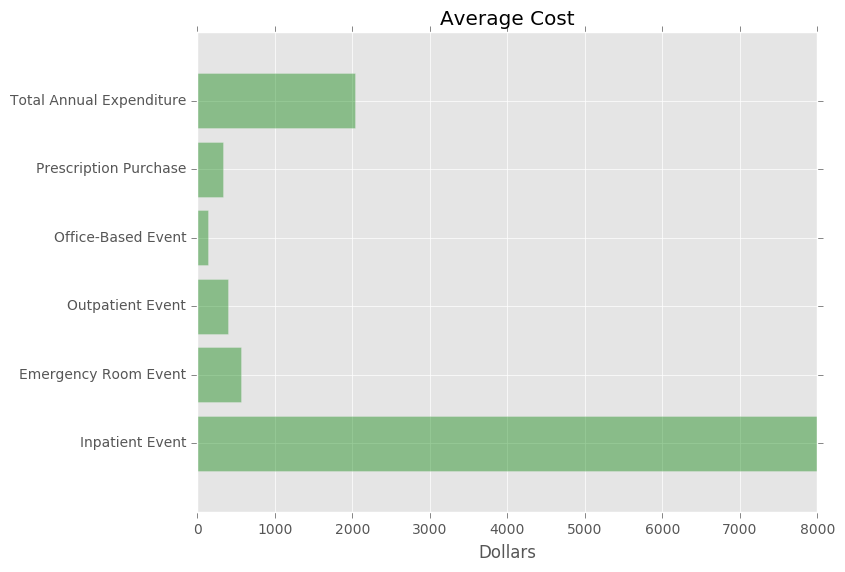

In [971]:
#import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
n_groups = 6

#means = (inpat_plt, er_plt, outpat_plt, off_plt, pres_plt, total_plt)


objects = ('Inpatient Event', 'Emergency Room Event', "Outpatient Event", "Office-Based Event", 'Prescription Purchase', 'Total Annual Expenditure')
y_pos = np.arange(len(objects))
performance = [inpat_plt, er_plt, outpat_plt, off_plt, pres_plt, total_plt]
 
plt.barh(y_pos, performance, align='center', alpha=0.4, color='g')
plt.yticks(y_pos, objects)
plt.xlabel('Dollars')
plt.title('Average Cost')
 
plt.show()


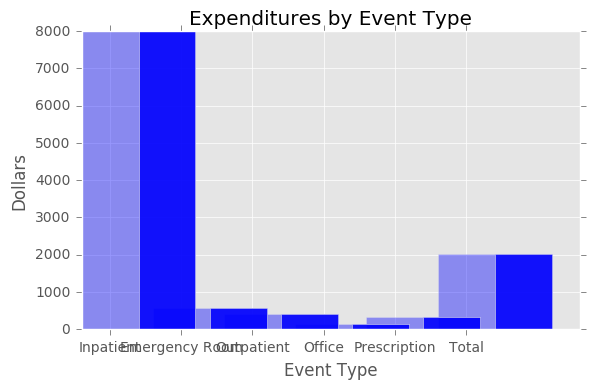

In [951]:
n_groups = 6

means = (inpat_plt, er_plt, outpat_plt, off_plt, pres_plt, total_plt)
#std_men = (2, 3, 4, 1, 2)

#means_women = (25, 32, 34, 20, 25)
#std_women = (3, 5, 2, 3, 3)

#fig, ax = plt.subplots()



index = np.arange(n_groups)
bar_width = 0.8

opacity = 0.4
#error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, means, bar_width,
                 alpha=opacity,
                 color='b')
                 #yerr=std_men,
                 #error_kw=error_config,
                 #label='Men')

rects2 = plt.bar(index + bar_width, means, bar_width,
                 alpha=opacity,
                 color='b')
                 #yerr=std_women,
                 #error_kw=error_config,
                 #label='Women')

rects3 = plt.bar(index + bar_width, means, bar_width,
                 alpha=opacity,
                 color='b')
                 #yerr=std_women,
                 #error_kw=error_config,
                 #label='Women')
            
rects4 = plt.bar(index + bar_width, means, bar_width,
                 alpha=opacity,
                 color='b')

rects5 = plt.bar(index + bar_width, means, bar_width,
                 alpha=opacity,
                 color='b')

rects5 = plt.bar(index + bar_width, means, bar_width,
                 alpha=opacity,
                 color='b')
            
plt.xlabel('Event Type')
plt.ylabel('Dollars')
plt.title('Expenditures by Event Type')
plt.xticks(index + bar_width / 2, ('Inpatient', 'Emergency Room', "Outpatient", "Office", 'Prescription', 'Total'))
plt.legend()

plt.tight_layout()
plt.show()

In [993]:
log_transform_mood_exp = mood_exp.ix[:,7:13]
log_transform_mood_exp = log_transform_mood_exp.apply(np.log10)
log_transform_mood_exp = log_transform_mood_exp.replace(to_replace = '-inf', value = 0)
log_transform_mood_exp.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 40005101 to 69667102
Data columns (total 6 columns):
IPXP14X       2056 non-null float64
ERXP14X       2056 non-null float64
OBXP14X       2048 non-null float64
OPXP14X       2054 non-null float64
RXXP14X       2056 non-null float64
total_paid    2056 non-null float64
dtypes: float64(6)
memory usage: 112.4 KB


In [1051]:
#bootstrap samples with inpatient visits
mood_df_w_pop = pd.concat([mood_exp, pop_df_w_dummies], axis = 1, join_axes=[mood_exp.index])
#inpatient_visits_mood = mood_df_w_pop[mood_df_w_pop["IPNUM"] >0]
#inpatient_visits_mood = inpatient_visits_mood.drop(["CCCODEX"], 1)
#print inpatient_visits_mood["IPNUM"].value_counts()
#print inpatient_visits_mood.info()

#from sklearn.utils import resample 
#resample = sklearn.utils.resample()

#y_inpatient_visits = np.array(inpatient_visits_mood["IPNUM"])
#X_inpatient_visits = np.array(inpatient_visits_mood.drop(["IPNUM", "total_paid","total_events", "total_paid_no_rx"], 1)


In [1068]:
mood_df_w_pop = pd.concat([mood_exp, pop_df_w_dummies], axis = 1, join_axes=[mood_exp.index])
#mood_df_w_pop.info(null_counts = True)
#print mood_df_w_pop["IPNUM"].value_counts()
inpatient_visits_mood = mood_df_w_pop[mood_df_w_pop["IPNUM"] > 0]
no_inpatient_visits_mood = mood_df_w_pop[mood_df_w_pop["IPNUM"] == 0]
#inpatient_visits_mood.info(null_counts = True)

y_inpatient_visits = inpatient_visits_mood["IPNUM"]
X_inpatient_visits = inpatient_visits_mood.drop(["IPNUM", "total_paid","total_events", "total_paid_no_rx"],1)
y_inpatient_visits_array = np.array(y_inpatient_visits)
X_inpatient_visits_array = np.array(X_inpatient_visits)

In [1078]:
no_inpatient_visits_mood.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 40005101 to 69667102
Data columns (total 50 columns):
CCCODEX                 1999 non-null int64
HHNUM                   1999 non-null int64
IPNUM                   1999 non-null int64
OPNUM                   1999 non-null int64
OBNUM                   1999 non-null int64
ERNUM                   1999 non-null int64
RXNUM                   1999 non-null int64
IPXP14X                 1999 non-null float64
ERXP14X                 1999 non-null float64
OBXP14X                 1999 non-null float64
OPXP14X                 1999 non-null float64
RXXP14X                 1999 non-null float64
total_paid              1999 non-null float64
total_events            1999 non-null int64
total_paid_no_rx        1999 non-null float64
AGE14X                  1999 non-null int64
male                    1999 non-null float64
female                  1999 non-null float64
white                   1999 non-null float64
black                   19

In [1079]:
print sum(no_inpatient_visits_mood["OBNUM"])/len(no_inpatient_visits_mood["OBNUM"])
print sum(no_inpatient_visits_mood["RXNUM"])/len(no_inpatient_visits_mood["RXNUM"])
print sum(no_inpatient_visits_mood["ERNUM"])/len(no_inpatient_visits_mood["ERNUM"])
print sum(no_inpatient_visits_mood["HHNUM"])/len(no_inpatient_visits_mood["HHNUM"])
print sum(no_inpatient_visits_mood["AGE14X"])/len(no_inpatient_visits_mood["AGE14X"])

4
2
0
0
49


In [1088]:
no_inpatient_visits_t_test = no_inpatient_visits_mood[no_inpatient_visits_mood["AGE14X"]>0]
print sum(no_inpatient_visits_t_test["AGE14X"])/len(no_inpatient_visits_t_test["AGE14X"])

49


In [1080]:
print sum(inpatient_visits_mood["OBNUM"])/57
print sum(inpatient_visits_mood["RXNUM"])/57
print sum(inpatient_visits_mood["ERNUM"])/57
print sum(inpatient_visits_mood["HHNUM"])/57
print sum(inpatient_visits_mood["AGE14X"])/57

20
4
0
1
33


In [1084]:
inpatient_age_t_test = inpatient_visits_mood[inpatient_visits_mood["AGE14X"]>0]
print sum(inpatient_age_t_test["AGE14X"])/len(inpatient_age_t_test["AGE14X"])

34


In [1096]:
import scipy as sc

no_inpatient_visits_t_test_array = np.array(no_inpatient_visits_t_test)
inpatient_age_t_test_array = np.array(inpatient_age_t_test)
sc.stats.ttest_ind(no_inpatient_visits_t_test_array, inpatient_age_t_test_array)

Ttest_indResult(statistic=array([ -6.68876238e+00,  -5.95121669e+00,  -7.38365733e+01,
        -4.96533828e+00,  -1.00284052e+01,  -2.56069169e+01,
        -5.87206889e+00,  -3.92567841e+01,  -1.36846507e+01,
        -7.47966310e+00,  -3.93435406e+00,  -4.34069153e+00,
        -2.82800162e+01,  -1.22507875e+01,  -3.32735022e+01,
         6.21964922e+00,  -4.55208535e-01,   4.55208535e-01,
         9.72829572e-01,  -5.59586069e-01,   6.29741057e-01,
         1.11184526e+00,  -2.22803011e+00,   2.75458544e+00,
        -3.44377955e+00,   1.37044101e+00,              nan,
                    nan,              nan,   2.31969168e+00,
         2.57665866e+00,   4.53244193e-01,   9.54200610e-01,
        -3.81370679e+00,  -3.21520677e+00,   3.35761797e-01,
         2.90705030e-01,   2.37299927e-01,   1.67754180e-01,
        -2.65096777e+00,  -2.10330904e+00,   6.15389103e-01,
         1.30748205e+00,   4.23971773e-01,   1.70650908e+00,
                    nan,  -9.13903284e-01,   7.42828322e-01

In [1056]:
from sklearn import cross_validation
from sklearn import utils

In [1063]:
#bootstrap_df = utils.resample()
X_inpatient_, y_inpatient_ = utils.resample(X_inpatient_visits_array,
                                            y_inpatient_visits_array, 
                                            n_samples = 10000)

In [1067]:
print X_inpatient_

[[  1.31400000e+03   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  1.31400000e+03   0.00000000e+00   1.20000000e+01 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.57000000e+02   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.31400000e+03   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  6.57000000e+02   5.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  1.31400000e+03   1.20000000e+01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [1001]:
#mood_exp.info()
mood_exp__pop_events = mood_exp.ix[:,1:7]
mood_exp__pop_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 40005101 to 69667102
Data columns (total 6 columns):
HHNUM    int64
IPNUM    int64
OPNUM    int64
OBNUM    int64
ERNUM    int64
RXNUM    int64
dtypes: int64(6)
memory usage: 112.4 KB


In [1003]:
mood_exp_pop = pd.concat([mood_exp__pop_events, log_transform_mood_exp, pop_df_w_dummies,], axis=1, join_axes=[mood_exp.index])
mood_exp_pop.info(null_counts=True)
#print mood_exp_pop["RXNUM"].value_counts(), mood_exp_pop["IPNUM"].value_counts(), mood_exp_pop["OPNUM"].value_counts(), mood_exp_pop["HHNUM"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 40005101 to 69667102
Data columns (total 47 columns):
HHNUM                   2056 non-null int64
IPNUM                   2056 non-null int64
OPNUM                   2056 non-null int64
OBNUM                   2056 non-null int64
ERNUM                   2056 non-null int64
RXNUM                   2056 non-null int64
IPXP14X                 2056 non-null float64
ERXP14X                 2056 non-null float64
OBXP14X                 2048 non-null float64
OPXP14X                 2054 non-null float64
RXXP14X                 2056 non-null float64
total_paid              2056 non-null float64
AGE14X                  2056 non-null int64
male                    2056 non-null float64
female                  2056 non-null float64
white                   2056 non-null float64
black                   2056 non-null float64
native_amer             2056 non-null float64
asian                   2056 non-null float64
multiple_races        

In [1008]:
mood_exp_pop_visits = mood_exp_pop.drop(["IPXP14X","OBXP14X","OPXP14X","RXXP14X","ERXP14X"], 1)
#mood_exp_pop_visits.info(null_counts=True)

In [660]:
#X_df_scatter = mood_exp.filter(['HHNUM',"IPNUM", "OPNUM", "OBNUM", "ERNUM", "RXXP14X"],1)
#pd.scatter_matrix(X_df_scatter, figsize= (15,15), diagonal ='kde')

Modeling

In [1009]:
#model using mood_exp_pop_visits to predict total costs
X_df = mood_exp_pop_visits.drop(["total_paid"],1)
X = np.array(X_df)
y = np.array(mood_exp['total_paid'])
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y,
                                                   test_size = 0.2, random_state = 0)

In [1010]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
print linear_reg.score(X_test, y_test)
#linear_reg.predict(X_test)

0.67869996056


In [1011]:
coef_table = pd.DataFrame(linear_reg.coef_)
coefs = coef_table.T
coefs.columns = list(X_df.columns)
coefs_format = coefs.T
coefs_format.columns = ["coefficient"]
coefs_format

,coefficient
HHNUM,1.620864e+02
IPNUM,8.264608e+03
OPNUM,4.702475e+02
OBNUM,1.195414e+02
ERNUM,-1.482441e+03
RXNUM,4.499977e+02
AGE14X,-1.193300e+01
male,1.764465e+02
female,-1.764465e+02
white,-6.243500e+01


In [1012]:
rand_for = sklearn.ensemble.RandomForestRegressor(n_estimators = 1000, max_features = 7, oob_score = True)
rand_for.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [1013]:
rand_for.oob_score_

0.4473419679608297

In [1016]:
feature_importances = rand_for.feature_importances_
feature_importances = pd.DataFrame(feature_importances)
features = feature_importances.T
features.columns =list(X_df.columns)
features_format = features.T
features_format.columns = ["feature_importances"]
#features_format

stats = pd.concat([features_format, coefs_format], 1)
stats.sort(columns="feature_importances", ascending = False)
#coef_table = pd.DataFrame(linear_reg.coef_)
#coefs = coef_table.T
#coefs.columns = list(X_df.columns)
#coefs_format = coefs.T
#coefs_format.columns = ["coefficient"]
#coefs_format


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature_importances,coefficient
OBNUM,0.202466,1.195414e+02
IPNUM,0.185427,8.264608e+03
RXNUM,0.175885,4.499977e+02
OPNUM,0.076288,4.702475e+02
AGE14X,0.068435,-1.193300e+01
ERNUM,0.045636,-1.482441e+03
HHNUM,0.035305,1.620864e+02
west,0.016816,4.604358e+02
bach_deg,0.012156,3.897282e+02
male,0.012109,1.764465e+02


ValueError: x and y must be the same size

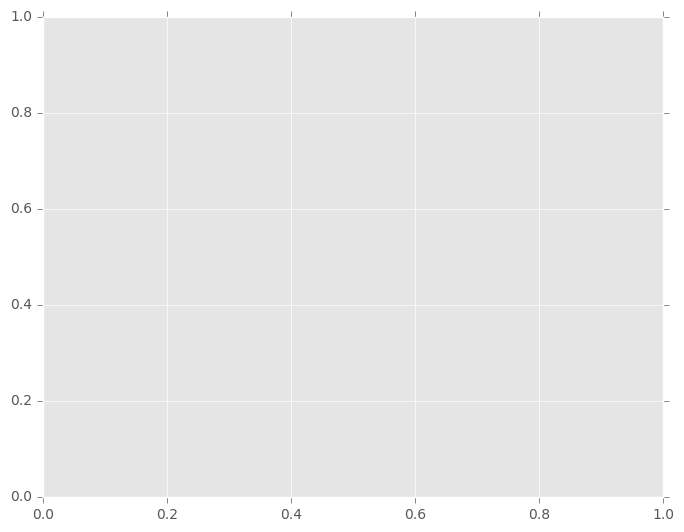

In [1017]:
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [779]:
#mood_exp.info(null_counts=True)
#mood_exp.head()
#mood_exp_pop
untransformed_df = pd.concat([mood_exp, pop_df_w_dummies], axis=1, join_axes=[mood_exp.index])
#untransformed_df.head()
inpatient_series = untransformed_df["IPNUM"].rename("inpat_visit")
inpatient_series[inpatient_series>1] = 1
inpatient_series.value_counts()

untransformed_df = pd.concat([untransformed_df, inpatient_series], axis=1, 
                             join_axes=[untransformed_df.index])
untransformed_df.head()
untransformed_df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 40005101 to 69667102
Data columns (total 50 columns):
CCCODEX                 2051 non-null int64
HHNUM                   2051 non-null int64
IPNUM                   2051 non-null int64
OPNUM                   2051 non-null int64
OBNUM                   2051 non-null int64
ERNUM                   2051 non-null int64
RXNUM                   2051 non-null int64
IPXP14X                 2051 non-null float64
OBXP14X                 2051 non-null float64
OPXP14X                 2051 non-null float64
RXXP14X                 2051 non-null float64
total_paid              2051 non-null float64
total_events            2051 non-null int64
total_paid_no_rx        2051 non-null float64
AGE14X                  2051 non-null int64
male                    2051 non-null float64
female                  2051 non-null float64
white                   2051 non-null float64
black                   2051 non-null float64
native_amer             20

In [914]:
df_inpat_classifier_df = untransformed_df.drop(untransformed_df.ix[:,7:14].head(0).columns, 1)
df_inpat_classifier_df = df_inpat_classifier_df.drop(["CCCODEX"], axis=1)
df_inpat_classifier_df.info()
df_inpat_classifier_df["inpat_visit"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 40005101 to 69667102
Data columns (total 42 columns):
HHNUM                   int64
IPNUM                   int64
OPNUM                   int64
OBNUM                   int64
ERNUM                   int64
RXNUM                   int64
AGE14X                  int64
male                    float64
female                  float64
white                   float64
black                   float64
native_amer             float64
asian                   float64
multiple_races          float64
any_private_ins         float64
public_only_ins         float64
uninsured               float64
NA_married              float64
DK_married              float64
refused_married         float64
married                 float64
widowed                 float64
divorced                float64
separated               float64
never_married           float64
under_16                float64
NA_edu                  float64
DK_edu                  float64


0    1994
1      57
Name: inpat_visit, dtype: int64

In [913]:
X_classifier = df_inpat_classifier_df.drop(["inpat_visit", "IPNUM"], 1)
#X_classifier.info()
y_classifier = np.array(list(df_inpat_classifier_df["inpat_visit"]))
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_classifier, y_classifier, test_size = 0.2, random_state = 0)

In [922]:
from sklearn.linear_model import LogisticRegression
inpatient_logit = linear_model.LogisticRegression()
inpatient_logit.fit(X_train_class, Y_train_class)
inpatient_logit.predict_proba(X_test_class)

array([[ 0.99068333,  0.00931667],
       [ 0.95468319,  0.04531681],
       [ 0.99260657,  0.00739343],
       [ 0.98459644,  0.01540356],
       [ 0.99511994,  0.00488006],
       [ 0.98115684,  0.01884316],
       [ 0.9879081 ,  0.0120919 ],
       [ 0.99880413,  0.00119587],
       [ 0.99300397,  0.00699603],
       [ 0.54103298,  0.45896702],
       [ 0.99563524,  0.00436476],
       [ 0.99074613,  0.00925387],
       [ 0.99387853,  0.00612147],
       [ 0.99692015,  0.00307985],
       [ 0.97481646,  0.02518354],
       [ 0.9824904 ,  0.0175096 ],
       [ 0.98073858,  0.01926142],
       [ 0.97009723,  0.02990277],
       [ 0.99700646,  0.00299354],
       [ 0.9798268 ,  0.0201732 ],
       [ 0.96619865,  0.03380135],
       [ 0.99226823,  0.00773177],
       [ 0.99635621,  0.00364379],
       [ 0.9906054 ,  0.0093946 ],
       [ 0.97746822,  0.02253178],
       [ 0.98920666,  0.01079334],
       [ 0.9966527 ,  0.0033473 ],
       [ 0.99762513,  0.00237487],
       [ 0.96615935,

In [921]:
inpatient_logit.score(X_test_class, Y_test_class)

0.97323600973236013

In [827]:
rand_forest_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, max_features = 6,oob_score=True, n_jobs = -1)

In [828]:
rand_forest_classifier.fit(X_classifier, y_classifier)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True,
            random_state=None, verbose=0, warm_start=False)

In [831]:
#rand_forest_classifier.estimators_
#rand_forest_classifier.classes_
#rand_forest_classifier.n_features_
rand_forest_classifier.oob_score_

0.97269624573378843

In [832]:
rand_forest_classifier.feature_importances_
#rand_forest_classifier

array([  3.93995204e-02,   3.39240237e-02,   1.39657152e-01,
         2.05642686e-01,   1.16986897e-01,   1.40417902e-01,
         1.86321512e-02,   1.96738849e-02,   1.47409864e-02,
         1.32555982e-02,   2.36253378e-04,   8.56101596e-04,
         1.08214416e-02,   1.61356807e-02,   1.92305754e-02,
         3.72763708e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.25947942e-02,   5.08638429e-03,
         1.18179515e-02,   2.67472001e-03,   1.75877831e-02,
         8.69625724e-03,   9.95207426e-05,   2.37776092e-05,
         7.14988713e-06,   1.13436195e-05,   1.03386415e-02,
         1.75131653e-02,   1.38473317e-02,   1.58636640e-02,
         8.45839661e-03,   3.18902551e-03,   4.52174017e-03,
         1.64820047e-02,   1.91370164e-02,   2.26893750e-02,
         1.60214663e-02])

In [841]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(log_class)

TypeError: __init__() takes at least 3 arguments (2 given)

In [837]:
from sklearn.linear_model import LogisticRegression
log_class = linear_model.LogisticRegression(n_jobs = -1)
#log_class.fit(X_classifier, y_classifier)

Outpatient Analysis: dropping and filtering columns

In [22]:
outpatient.shape
#outpatient.OPDATEMM.value_counts()
#outpatient.DUPERSID.value_counts()

(15144, 71)

In [34]:
outpatient.columns[37:-4]

Index([u'OPXP14X', u'OPTC14X', u'OPFSF14X', u'OPFMR14X', u'OPFMD14X',
       u'OPFPV14X', u'OPFVA14X', u'OPFTR14X', u'OPFOF14X', u'OPFSL14X',
       u'OPFWC14X', u'OPFOR14X', u'OPFOU14X', u'OPFOT14X', u'OPFXP14X',
       u'OPFTC14X', u'OPDSF14X', u'OPDMR14X', u'OPDMD14X', u'OPDPV14X',
       u'OPDVA14X', u'OPDTR14X', u'OPDOF14X', u'OPDSL14X', u'OPDWC14X',
       u'OPDOR14X', u'OPDOU14X', u'OPDOT14X', u'OPDXP14X', u'OPDTC14X'],
      dtype='object')

In [217]:
#outpatient.ix[:,3:5]
#outpatient['OPCCC1X'].value_counts()

In [64]:
y_start = outpatient.columns.get_loc("OPXP14X")
y_end = outpatient.columns.get_loc("OPDTC14X")
print y_start, ",", y_end
responses = outpatient.ix[:,y_start:y_end]
responses.shape

37 , 66


(15144, 29)

In [81]:
make = outpatient.OPDTC14X.value_counts()
len(make)

1499

In [137]:
def filter_negs(df):
    '''
    drop rows with a not ascertained, DK, or refused
    '''
    for col in df:
        df = df[df[col] > -2]
    return df

In [141]:
#make this one work!

filts = outpatient[outpatient["OTHSVCE"] != 95]

def filter_no_services(df):
    df = df.ix[:, "LABTEST":"OTHSVCE"]
    for colu in df:
        for i in colu:
            if i == 95:         
                

In [168]:
    def response_columns(df):
        y_start = df.columns.get_loc("OPXP14X")
        y_end = df.columns.get_loc("OPDTC14X")
        Y = df.ix[:,y_start:y_end]
        x_end = df.columns.get_loc('OPCCC4X')
        X = df[list(df.columns[:x_end])]
        return Y, X

In [227]:
    def dummy_cols(X):

        '''
        DRSPLTY, OPAT Doctor's specialty, and medptype -- half are inapplicable

        '''
        X_dummies = pd.concat([pd.get_dummies(X[col]) for col in X], axis=1, keys=X.columns)

        return X_dummies

In [173]:
Y_df, X_df = response_columns(outpatient)
print X_df.shape, Y_df.shape
X_dummies = pd.concat([pd.get_dummies(X_df[col]) for col in X_df], axis=1, keys=X_df.columns)
print X_dummies.shape

(15144, 33) (15144, 29)
(15144, 39372)


In [215]:
    def filter_negs(df):
        '''
        drop rows with a not ascertained, DK, or refused
        '''
        for col in df:
            df = df[df[col] > -2]
        return df

    def drop_cols(df):
        '''
        See if EVNTIDX is a key in another table
        EVENTRN read if event round is for the same condition or linked events
        Read about MPCDATA
        OPDATEMM could be interesting for readmission rate
        OPAT Doctor's specialty and medptype -- half are inapplicable
        '''
        df = df.drop(["DUID","PID", "FFEEIDX", "PANEL", "OPDATEYR", "EVNTIDX", "FFEEIDX","PANEL",
                        "OPDATEYR"], 1)

        return df

    def response_columns(df):
        y_start = df.columns.get_loc("OPXP14X")
        y_end = df.columns.get_loc("OPDTC14X")
        Y = df.ix[:,y_start:y_end]
        x_end = df.columns.get_loc('OPCCC4X')
        X = df[list(df.columns[:x_end])]
        return Y, X

    def dummy_cols(X):

        '''
        DRSPLTY, OPAT Doctor's specialty, and medptype -- half are inapplicable

        '''
        X_dummies = pd.concat([pd.get_dummies(X[col]) for col in X], axis=1, keys=X.columns)

        return X_dummies

In [220]:
out_negs = filter_negs(outpatient)
out_drop = drop_cols(out_negs)
out_response, out_X = response_columns(out_drop)
#X_dummies = dummy_cols(out_X)

print outpatient.shape, out_drop.shape, out_response.shape, out_X.shape, #X_dummies

(15144, 71) (13006, 65) (13006, 29) (13006, 27)


In [219]:
X_dummies.shape


(13006, 17863)

In [222]:
from sklearn import multioutput
from sklearn import ensemble
multi = multioutput.MultiOutputRegressor(ensemble.RandomForestRegressor(random_state=0),n_jobs = -1)

In [223]:
X_model = np.array(X_dummies)
Y_model = np.array(out_response)

In [224]:
X_train, X_test, Y_train, Y_test = train_test_split(X_model, Y_model, test_size = 0.2, random_state = 0)

In [226]:
#multi.fit(X_train, Y_train)

In [ ]:
#print multi.predict(X_test[0]),Y_test[0]
#multi.score()

In [214]:
'''
class OutpatientClean:
    """input raw outpatient data set, output clean df"""

    def __init__(self, data):
        self.df = data

    def filter_negs(self):
        '''
        drop rows with a not ascertained, DK, or refused
        '''
        for col in self.df:
            self.df = self.df[self.df[col] > -2]
        return self.df

    def drop_cols(self):
        '''
        See if EVNTIDX is a key in another table
        EVENTRN read if event round is for the same condition or linked events
        Read about MPCDATA
        OPDATEMM could be interesting for readmission rate
        OPAT Doctor's specialty and medptype -- half are inapplicable
        '''
        df = self.df.drop(["DUID","PID", "FFEEIDX", "PANEL", "OPDATEYR", "EVNTIDX", "FFEEIDX","PANEL",
                        "OPDATEYR"], 1)

        return self.df

    def response_columns(self):
        y_start = self.df.columns.get_loc("OPXP14X")
        y_end = self.df.columns.get_loc("OPDTC14X")
        Y = self.df.ix[:,y_start:y_end]
        x_end = self.df.columns.get_loc('OPCCC4X')
        X = self.df[list(df.columns[:x_end])]
        return Y, X
'''

In [208]:
cleaner = OutpatientClean(outpatient)
#X, Y = cleaner.X, cleaner.Y

##Conditions Analysis

In [266]:
#find columns ex: saq_cols = [col for col in con.columns if 'SAQ' in col]
#saq_cols
#top 10: 401 = essential hypertension, 272 = disease of lipid metabolism*
#719 = Joint disorder, 780 = general symptoms
#460 = acute nasopharyngitis, 250 = 
# 311 = depressive disorder nec 477 = allergic rhinitis, 
#724 = back disorder, 300 = neurotic disorders
con['ICD9CODX'].astype(str)
#con.info()
dep = con[con['ICD9CODX'] == '311']
not_dep = con[con['ICD9CODX'] != '311']
print dep.shape, not_dep.shape
#dep.info()
#con.info()
#con["ICD9CODX"].value_counts()

(2464, 28) (114215, 28)


In [859]:
#con_no_condition = con[con['ICD9CODX'] == '-1']
con_hypertention = con[con['ICD9CODX'] == '401']
con_depressive_disorder = con[con['ICD9CODX'] == '311']

#con_depressive_disorder['ICD9PROX'].value_counts()
con_procedures = con[con['ICD9PROX'] > -1]
#con_procedures['ICD9CODX'].value_counts()
con_procedures['ICD9PROX'].value_counts()
#procedures_joint_pain = con_procedures[con_procedures['ICD9CODX'] > "719"]
procedures_joint_pain['ICD9PROX'].value_counts()

#top procedures: (578 total for number 23, top hit) 23: Tooth removal and restoration, 86 skin and subq operations
#81 Joint repair, 99 other nonoperative proc, 45 intest incis/excis/anast

#print con_procedures.shape, con.shape
#procedures: 

#KEEP=DUPERSID AGE SEX EDUYRDG EDRECODE

#procedure 99 vs 86 for joint pain --visits, expenditures, etc
#CCCODEX aggregation of ICD-9-CM codes
mood_disorders = con[con['CCCODEX'] == 657]
anxiety = con[con['CCCODEX'] == 2988]
mood_events =  mood_disorders.ix[:,'HHNUM':'RXNUM']
mood_repeat = mood_disorders[mood_disorders['DUPERSID'] == 47790101]
#CONDN is the condition number and uniquely identifies each condition reported for an individual. 
#The range on this file for CONDN is 11-631 and the range of total records for any one person on 
#the file is 1-61.

diabetes = con[con['ICD9CODX'] == '250']
depression = con[con['ICD9CODX'] == '311']
hypertension = con[con['ICD9CODX'] == '401']

check_link = rx[rx['LINKIDX'] == 477901010081]

#rx.head()
mood_repeat.head()

#diabetes.shape, depression.shape, mood_disorders.shape, mood_events.shape, check_link.head()
#mood_disorders['IPNUM'].value_counts()
mood_disorder_df = mood_disorders.filter(['DUPERSID','CCCODEX', "HHNUM", 'IPNUM', 'OPNUM', 'OBNUM', 'ERNUM', 'RXNUM'], 1)
mood_disorder_single_duper = mood_disorder_df.groupby('DUPERSID').sum()
mood_disorder_single_duper.head()

#Others
not_mood_disorders= con[con['CCCODEX'] != 657]

not_mood_disorder_df = not_mood_disorders.filter(['DUPERSID','CCCODEX', "HHNUM", 'IPNUM', 'OPNUM', 'OBNUM', 'ERNUM', 'RXNUM'], 1)

not_mood_disorder_single_duper = not_mood_disorder_df.groupby('DUPERSID').sum()

#not_mood_disorder_single_duper.head(20)
#not_mood_disorder_df.head()
#not_mood_disorder_single_duper.head(20)

          CCCODEX  HHNUM  IPNUM  OPNUM  OBNUM  ERNUM  RXNUM
DUPERSID                                                   
40005101      657      0      0      0      0      0      2
40014103      657      0      0      0      1      0      0
40020101      657      0      0      0      0      0      0
40020102      657      0      0      0     13      0      0
40020103      657      0      0      0     13      0      0


In [269]:
#con['ICD9PROX'].value_counts()
#con['CONDN'].value_counts()

In [4]:
#AGEDIAG = AGE WHEN DIAGNOSED
#ERNUM = # of ER events associated w/ condition
#HHNUM = HOME HEALTH EVENTS ASSOC. W/ CONDITION
#IPNUM = inpatient events assoic w/condition
#OBNUM = office-based events associated w/ cond
#OPNUM = outpatient events assoc w/ cond
#RXNUM = number of prescribed medicines assoc w/ cond
dep_cols = dep.filter(items=["DUPERSID","ERNUM", "HHNUM",
                            "IPNUM", "OBNUM","OPNUM", "RXNUM"], axis = 1)


In [6]:
rx_cols = rx.filter(items = ["DUPERSID", "RXXP14X"], axis = 1)
# total exp for event
inpatient_cols = inpatient.filter(items = ["DUPERSID", "IPXP14X"], axis = 1)
# outpatient_cols = total exp for event
outpatient_cols = outpatient.filter(items = ["DUPERSID", "OPXP14X"], axis = 1)
office_cols = office.filter(items = ["DUPERSID", "OBXP14X"], axis = 1)
#SUM OF HHSF14X - HHOT14X
hh_cols = hh.filter(items = ["DUPERSID", "HHXP14X"], axis = 1)
print inpatient_cols['DUPERSID'].value_counts().max() 
print rx_cols['DUPERSID'].value_counts().max()
print outpatient_cols['DUPERSID'].value_counts().max()
print office_cols['DUPERSID'].value_counts().max()
print hh_cols['DUPERSID'].value_counts().max()

12
344
153
391
67


In [7]:
inpat_grouped = inpatient_cols.groupby('DUPERSID').sum()
#inpat_grouped.index.value_counts()
inpat_grouped.reset_index(level=0, inplace = True)

rx_grouped = rx_cols.groupby('DUPERSID').sum()
rx_grouped.reset_index(level=0, inplace = True)

outpatient_grouped = outpatient_cols.groupby('DUPERSID').sum()
outpatient_grouped.reset_index(level=0, inplace = True)

office_grouped = office_cols.groupby('DUPERSID').sum()
office_grouped.reset_index(level=0, inplace = True)

hh_grouped = hh_cols.groupby('DUPERSID').sum()
hh_grouped.reset_index(level=0, inplace = True)

In [8]:
print inpat_grouped.shape, dep_cols.shape

(2204, 2) (2464, 7)


In [9]:
result = pd.merge(dep_cols, inpat_grouped, how='left', on=['DUPERSID'])
result = pd.merge(result, rx_grouped, how='left', on=['DUPERSID'])
result = pd.merge(result, outpatient_grouped, how='left', on=['DUPERSID'])
result = pd.merge(result, hh_grouped, how='left', on=['DUPERSID'])
result.fillna(0, inplace = True)
print result.shape
result.head(1)

(2464, 11)


,DUPERSID,ERNUM,HHNUM,IPNUM,OBNUM,OPNUM,RXNUM,IPXP14X,RXXP14X,OPXP14X,HHXP14X
0,40005101,0,0,0,0,0,2,0.0,7923.74,0.0,0.0


In [10]:
result['total_costs'] = result[['IPXP14X','RXXP14X','OPXP14X', 'HHXP14X']].sum(axis = 1)

In [11]:
def has_prescription(col):
    if col > 0:
        return 1
    else:
        return 0

result['prescribed'] = result.RXNUM.map(lambda x: has_prescription(x))
result.head(5)

,DUPERSID,ERNUM,HHNUM,IPNUM,OBNUM,OPNUM,RXNUM,IPXP14X,RXXP14X,OPXP14X,HHXP14X,total_costs,prescribed
0,40005101,0,0,0,0,0,2,0.00,7923.74,0.00,0.0,7923.74,1
1,40014103,0,0,0,1,0,0,0.00,8.22,1126.02,0.0,1134.24,0
2,40020101,0,0,0,0,0,0,7142.41,41.40,0.00,0.0,7183.81,0
3,40020102,0,0,0,13,0,0,0.00,0.00,0.00,0.0,0.00,0
4,40020103,0,0,0,13,0,0,0.00,0.00,0.00,0.0,0.00,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14d88d610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15aebef50>]], dtype=object)

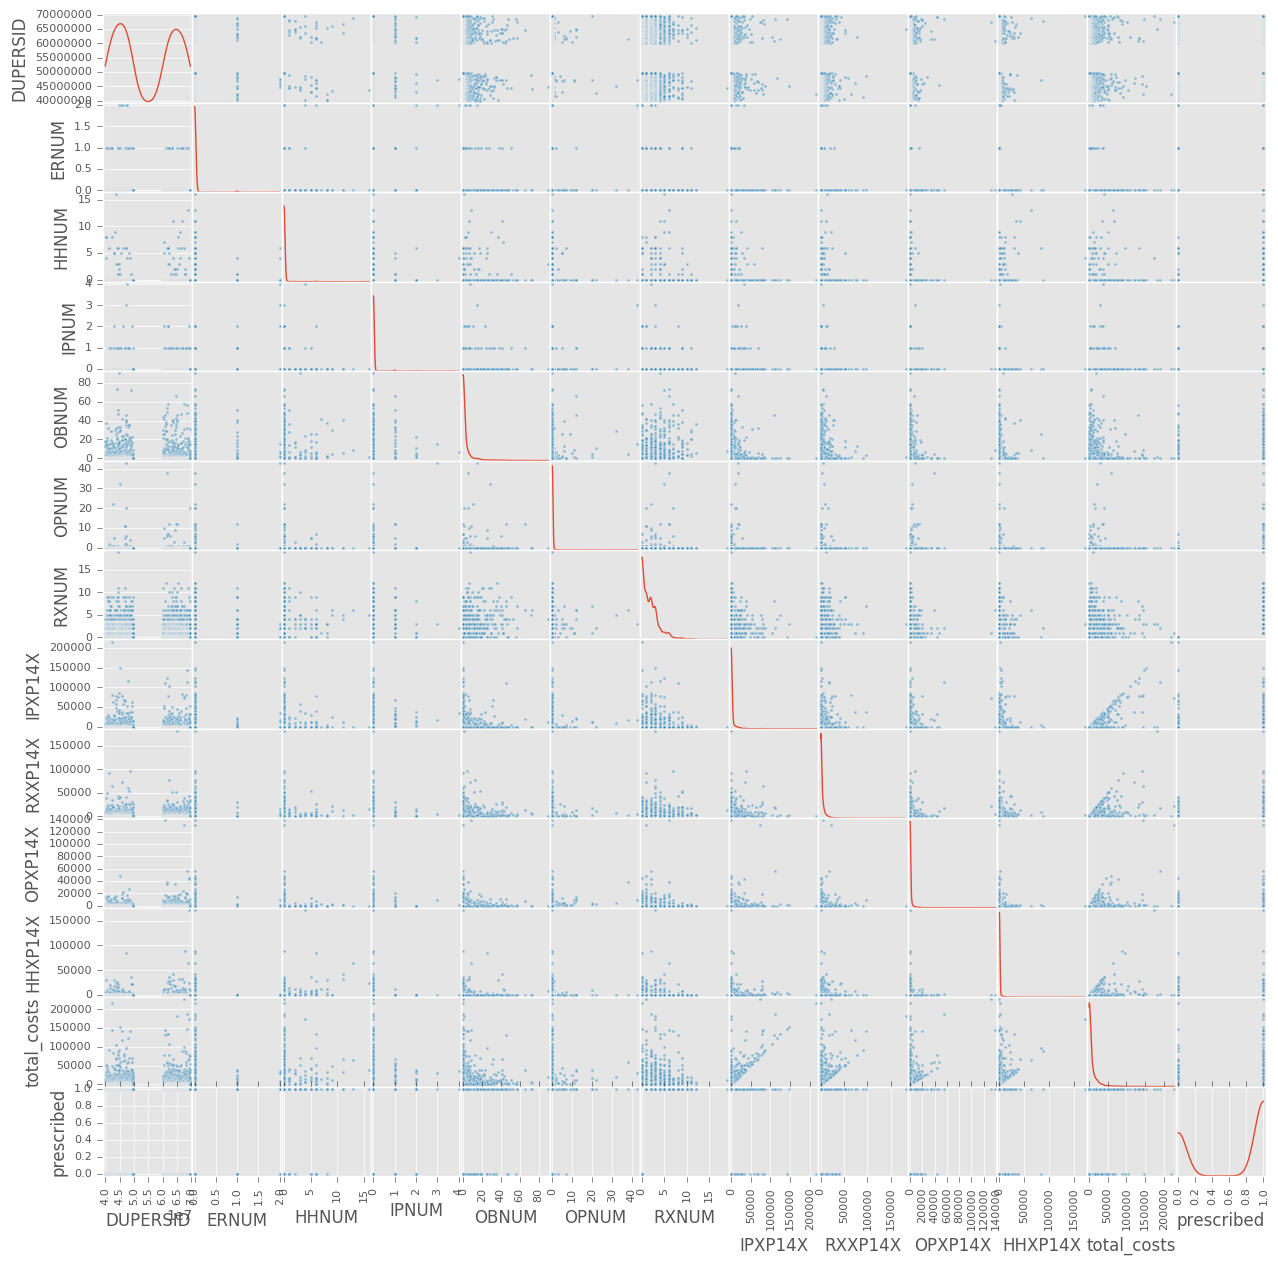

In [38]:
pd.scatter_matrix(result, figsize= (15,15), diagonal ='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1613da190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x163675a10>]], dtype=object)

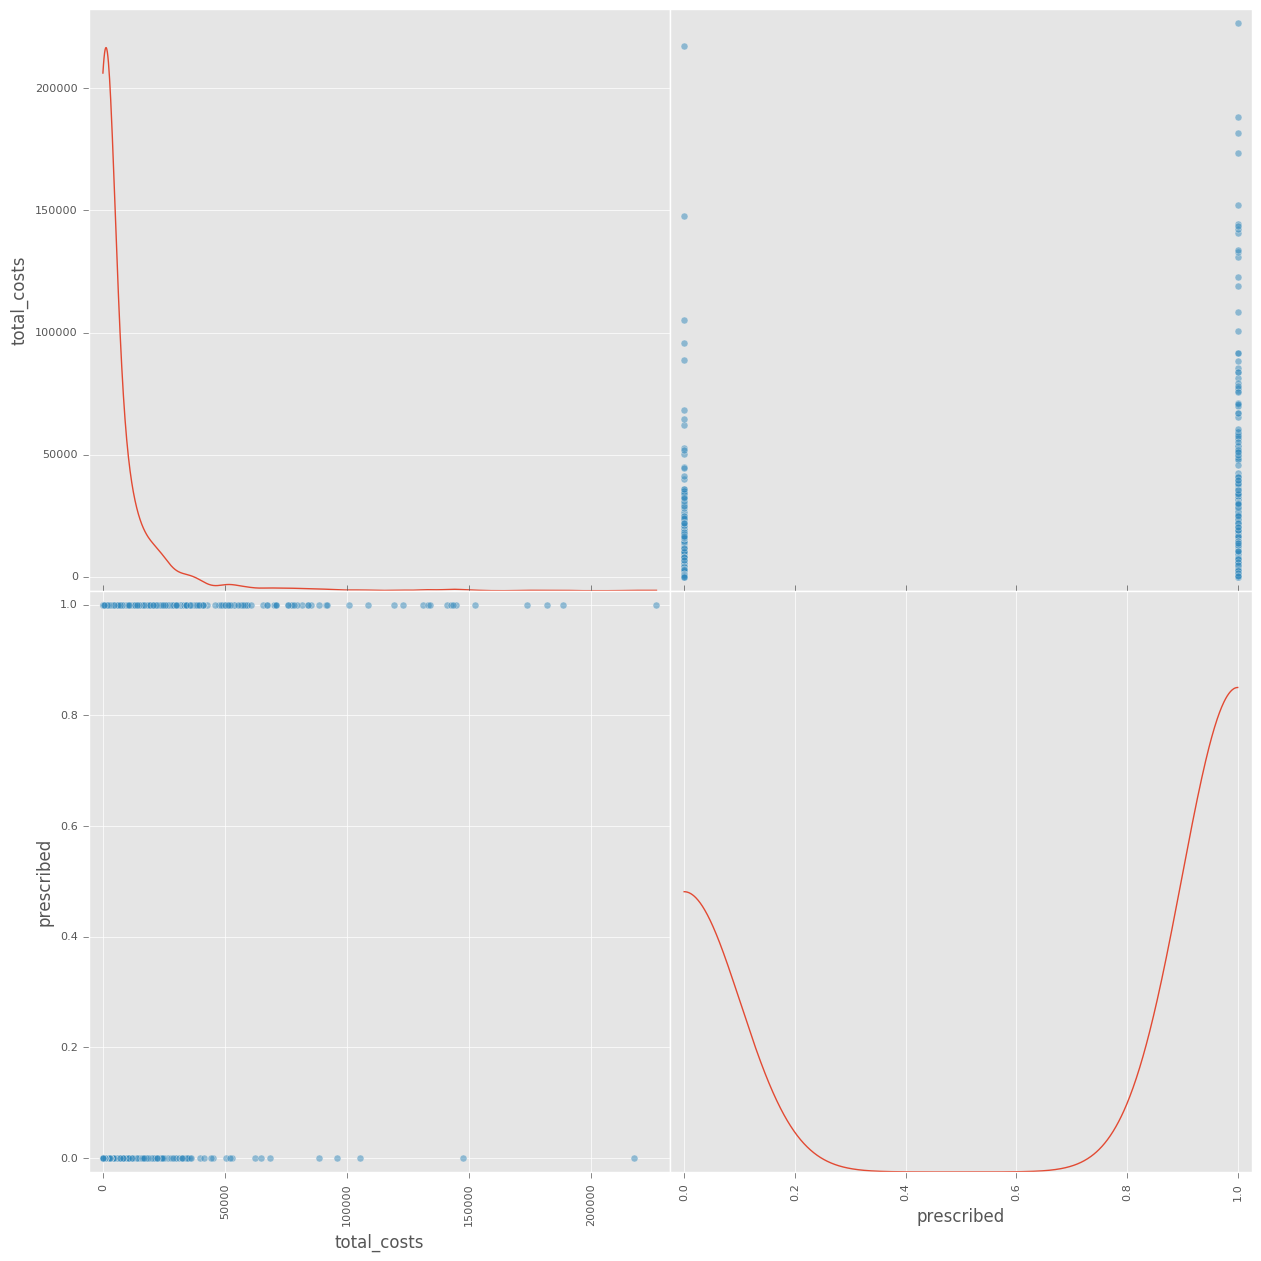

In [43]:
pd.scatter_matrix(result[['total_costs','prescribed']], figsize= (15,15), diagonal ='kde', s = 100)

In [68]:
np.linspace?

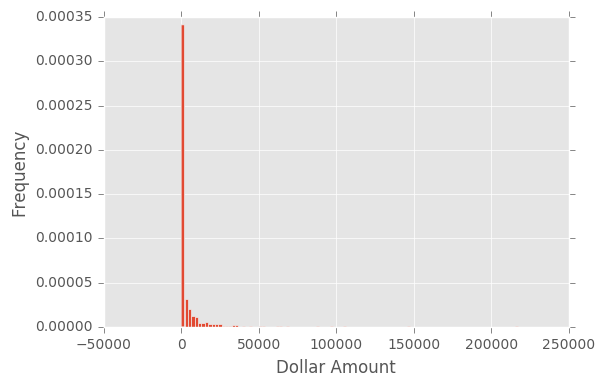

In [75]:
result[result['prescribed']==0]["total_costs"].hist(normed = True, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Dollar Amount')

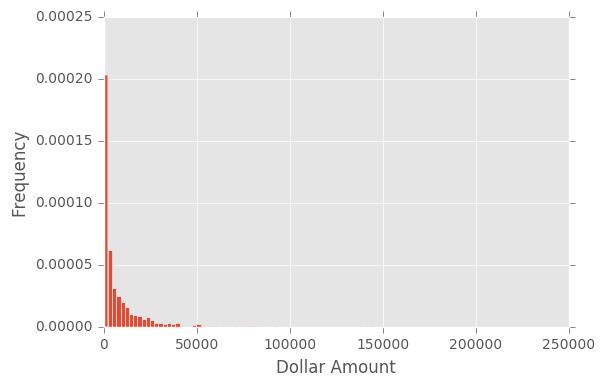

In [76]:
result[result['prescribed']==1]["total_costs"].hist(normed = True, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Dollar Amount')

In [12]:
lin_reg = sklearn.linear_model.LinearRegression()

In [54]:
model_df = result.drop(['DUPERSID', "IPXP14X", "RXXP14X", "OPXP14X", "HHXP14X"], axis = 1)
print model_df.head()
X = np.array(model_df.drop("total_costs", axis =1))
y = np.array(model_df["total_costs"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

   ERNUM  HHNUM  IPNUM  OBNUM  OPNUM  RXNUM  total_costs  prescribed
0      0      0      0      0      0      2      7923.74           1
1      0      0      0      1      0      0      1134.24           0
2      0      0      0      0      0      0      7183.81           0
3      0      0      0     13      0      0         0.00           0
4      0      0      0     13      0      0         0.00           0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16534e410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16938a090>]], dtype=object)

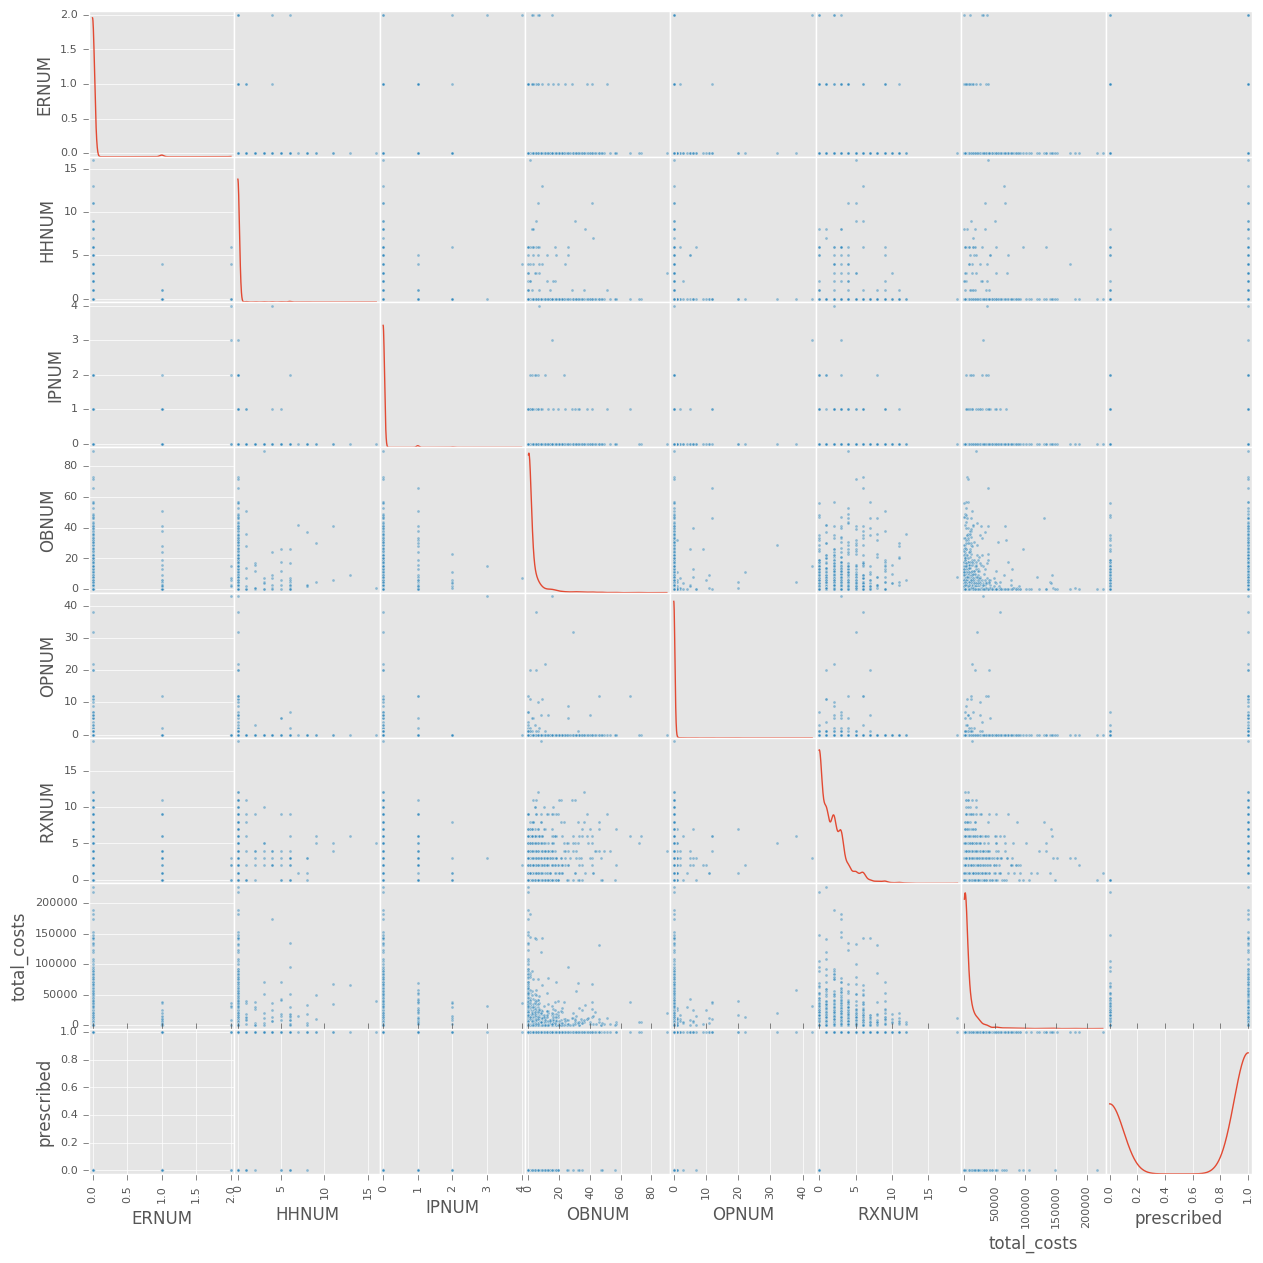

In [60]:
pd.scatter_matrix(model_df, figsize= (15,15), diagonal ='kde')

In [65]:
#student_resid = model_df.outlier_test()['student_resid']
#plt.scatter(credit_model.fittedvalues, student_resid)
#plt.xlabel('Fitted values of AVGEXP')
#plt.ylabel('Studentized Residuals')

In [100]:
model_df.head()

,ERNUM,HHNUM,IPNUM,OBNUM,OPNUM,RXNUM,total_costs,prescribed
0,0,0,0,0,0,2,7923.74,1
1,0,0,0,1,0,0,1134.24,0
2,0,0,0,0,0,0,7183.81,0
3,0,0,0,13,0,0,0.00,0
4,0,0,0,13,0,0,0.00,0


In [97]:
lin_reg.fit(X_train, y_train)
lin_reg.get_params
lin_reg.predict(X_test)
lin_reg.score(X_test,y_test)

0.06438947274717044

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [131]:
rand_for = sklearn.ensemble.RandomForestRegressor(n_estimators = 7, max_features = 3, oob_score = True)
rand_for.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [132]:
rand_for.oob_score_

-0.050739027158380523

In [124]:
print rand_for.feature_importances_
model_features = model_df.drop("total_costs", axis = 1)
print model_features.head(1)

[ 0.00984134  0.23472183  0.03333737  0.42514856  0.02645779  0.23537844
  0.03511467]
   ERNUM  HHNUM  IPNUM  OBNUM  OPNUM  RXNUM  prescribed
0      0      0      0      0      0      2           1


In [94]:
ridge_reg = sklearn.linear_model.Ridge(alpha = .5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge_reg.fit(X_train, y_train) 
ridge_reg.coef_

array([ -4.28303164e+03,   3.10642506e+03,   7.58370236e+03,
        -6.52410919e+00,   5.50044958e+02,   7.37521247e+02,
         2.40787716e+03])

In [95]:
print model_df.drop("total_costs", axis =1).head(1)
print lin_reg.coef_
print ridge_reg.coef_

   ERNUM  HHNUM  IPNUM  OBNUM  OPNUM  RXNUM  prescribed
0      0      0      0      0      0      2           1
[ -4.39869587e+03   3.10711872e+03   7.68126918e+03  -6.66544011e+00
   5.49528837e+02   7.36870021e+02   2.41180346e+03]
[ -4.28303164e+03   3.10642506e+03   7.58370236e+03  -6.52410919e+00
   5.50044958e+02   7.37521247e+02   2.40787716e+03]


In [ ]:
lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [125]:
lst = [1, 2, 3, 1, 2, 3]
s = pd.Series([1, 2, 3, 10, 20, 30], lst)
grouped = s.groupby(level=0)
s
grouped.sum()

1    11
2    22
3    33
dtype: int64

In [123]:
ids = inpatient_cols['DUPERSID']


1    11
2    22
3    33
dtype: int64

In [72]:
def aggregate_costs(df):
    duper = df.ix[:,0]
    cost = df.ix[:,1]

In [61]:
#dupers = inpatient_cols.ix[:,0]
#costs = inpatient_cols.ix[:,1]
#s = pd.Series(costs, dupers)
#grouped = s.groupby(level=0)
#grouped.sum()
#costs

In [121]:
df_r = pd.DataFrame([2,1,2,4,5])
df_r["1"] = [1,2,1,3,5]

grouped = df_r.groupby(level =0)
grouped.sum()

,0,1
0,2,1
1,1,2
2,2,1
3,4,3
4,5,5


In [105]:
arr.head()

,data,tar
0,-0.623544,-0.031392
1,1.556494,-1.294183
2,-1.871825,-0.583214
3,1.552891,-0.297788
4,0.334318,-0.628229


In [34]:
conditions_2014 = pd.read_csv("data/R_download/2014 - conditions.csv")
conditions_2014.head(2)

,Unnamed: 0,DUID,PID,DUPERSID,CONDN,CONDIDX,PANEL,CONDRN,AGEDIAG,CRND1,CRND2,CRND3,CRND4,CRND5,INJURY,ACCDNWRK,ICD9CODX,ICD9PROX,CCCODEX,HHNUM,IPNUM,OPNUM,OBNUM,ERNUM,RXNUM,PERWT14F,VARSTR,VARPSU
0,1,40001,101,40001101,51,400011010051,18,3,-1,-1,-1,1,0,0,2,-1,692,-1,253,0,0,0,0,0,0,6967.623864,1144,2
1,2,40001,101,40001101,61,400011010061,18,3,-1,-1,-1,1,0,0,2,-1,388,-1,94,0,0,0,1,0,0,6967.623864,1144,2


In [13]:
outpatient_2014 = pd.read_csv("data/R_download/2014 - outpatient.csv")

In [15]:
#def filtering(df):
df_out = outpatient_2014[outpatient_2014 > 0]
df_out.shape

(15144, 71)

In [71]:
#conditions_2014.info()
#conditions_2014[conditions_2014["ICD9CODX"] >10]
#conditions_2014["CCCODEX"].max()
#conditions_2014["CCCODEX"].min()
#conditions_2014.sort('CCCODEX', ascending = False)


In [62]:
#Chars file
#hospital = pd.read_excel("data/2014FYHospitalCensusandCharges.xlsx")
#reason entered hospital
reason_cols = [col for col in pop.columns if 'RSNINHOS' in col]
print list(reason_cols)

[]


In [76]:
#inpatient.info()
#inpatient["RSNINHOS"].value_counts()
inpatient["ANYOPER"].value_counts() #if used change format
inpatient["DSCHPMED"].value_counts()

2 NO                  1424
1 YES                 1335
-8 DK                  134
-9 NOT ASCERTAINED      63
-7 REFUSED               1
Name: DSCHPMED, dtype: int64

In [78]:
#inpatient["IPCCC1X"].value_counts()

In [87]:
inpatient["IPCCC2X"].value_counts()

-1      2335
 127      27
 657      25
 101      22
 133      18
 108      16
 159      16
 651      15
 259      15
 55       14
 100      14
 122      14
 196      13
 244      12
 205      11
 106      10
 49       10
 102      10
 19       10
 128       9
 3         9
 109       9
 117       9
 211       8
 204       8
 210       8
 149       7
 231       7
 95        7
 7         6
        ... 
 146       1
 226       1
 243       1
 48        1
 44        1
 11        1
 652       1
 257       1
 653       1
 14        1
 8         1
 6         1
 237       1
 29        1
 92        1
 140       1
 215       1
 199       1
 206       1
 202       1
 165       1
 154       1
 93        1
 240       1
 125       1
 130       1
 123       1
 136       1
 111       1
 252       1
Name: IPCCC2X, dtype: int64

In [5]:
print inpatient["IPCCC3X"].value_counts()
print inpatient["IPCCC4X"].value_counts()

<function pandas.core.algorithms.value_counts>

In [88]:
inpatient["FFBEF14"].value_counts()

-1 INAPPLICABLE       2948
-9 NOT ASCERTAINED       5
0                        3
1                        1
Name: FFBEF14, dtype: int64

In [84]:
print inpatient[["IPTC14X", "IPFTC14X", "IPDTC14X"]].head()
print inpatient["IPFTC14X"][0] + inpatient["IPDTC14X"][0]

    IPTC14X  IPFTC14X  IPDTC14X
0  45288.50  33799.50   11489.0
1  33745.00  28182.00    5563.0
2  10131.44   7727.44    2404.0
3  17290.99  14681.99    2609.0
4   5784.81   4284.81    1500.0
45288.5


In [73]:
inpat = inpatient.drop("DLVRTYPE", 1) 
#delivery type 
inpat = inpatient.drop("FFBEF14", 1)
#FFBEF14 number of visits before 2014, mostly inapplicable 

In [48]:
#with open('data/2014_prescribed_medicines.dat','r') as f:
#    prescribed_df = pd.DataFrame(l.rstrip().split() for l in f)

In [57]:
#prescribed_df.info()
#prescribed = pd.read_csv('data/2014_prescribed_medicines.dat')

In [55]:
#prescribed_df.info()
#prescribed_df.head()
inpatient.head(5)

,DUID,PID,DUPERSID,EVNTIDX,EVENTRN,ERHEVIDX,FFEEIDX,PANEL,MPCDATA,IPBEGYR,IPBEGMM,IPENDYR,IPENDMM,NUMNIGHX,NUMNIGHT,EMERROOM,SPECCOND,RSNINHOS,DLVRTYPE,ANYOPER,IPCCC1X,IPCCC2X,IPCCC3X,IPCCC4X,DSCHPMED,FFIPTYPE,FFBEF14,IPXP14X,IPTC14X,IPFSF14X,IPFMR14X,IPFMD14X,IPFPV14X,IPFVA14X,IPFTR14X,IPFOF14X,IPFSL14X,IPFWC14X,IPFOR14X,IPFOU14X,IPFOT14X,IPFXP14X,IPFTC14X,IPDSF14X,IPDMR14X,IPDMD14X,IPDPV14X,IPDVA14X,IPDTR14X,IPDOF14X,IPDSL14X,IPDWC14X,IPDOR14X,IPDOU14X,IPDOT14X,IPDXP14X,IPDTC14X,IMPFLAG,PERWT14F,VARSTR,VARPSU
0,40002,101,40002101,400021010111,ROUND 5,-1,-1,PANEL 18,1 HAS MPC DATA,2014,8,2014,8,6,-1 INAPPLICABLE,1 YES,2 NO,91 OTHER (SPECIFY),-1 INAPPLICABLE,1 YES,-1,-1,-1,-1,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE,10745.02,45288.50,0.0,7562.69,0.00,1216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,8778.69,33799.50,0.0,1604.01,0.00,362.32,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1966.33,11489.0,2 COMPLETE MPC DATA,9804.882572,1097,1
1,40014,101,40014101,400141010541,ROUND 4,-1,-1,PANEL 18,1 HAS MPC DATA,2014,4,2014,4,1,-1 INAPPLICABLE,2 NO,1 YES,1 OPERATION OR SURGICAL PROCEDURE,-1 INAPPLICABLE,1 YES,161,-1,-1,-1,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE,1191.29,33745.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,28182.00,0.0,1191.29,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1191.29,5563.0,2 COMPLETE MPC DATA,5849.317950,1157,1
2,40019,103,40019103,400191030011,ROUND 3,-1,-1,PANEL 18,2 NO MPC DATA,2013,12,2014,1,7,-1 INAPPLICABLE,1 YES,1 YES,2 TREATMENT/THERAPY,-1 INAPPLICABLE,1 YES,118,-1,-1,-1,1 YES,-1 INAPPLICABLE,-1 INAPPLICABLE,823.58,10131.44,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,7727.44,0.0,823.58,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,823.58,2404.0,1 COMPLETE HC DATA,4853.439459,1024,2
3,40020,101,40020101,400201010501,ROUND 5,-1,-1,PANEL 18,1 HAS MPC DATA,2014,10,2014,10,2,-1 INAPPLICABLE,2 NO,1 YES,4 GIVE BIRTH TO A BABY (MOTHER),1 VAGINAL DELIVERY,-8 DK,196,-1,-1,-1,-8 DK,-1 INAPPLICABLE,-1 INAPPLICABLE,7142.41,17290.99,0.0,0.00,6273.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6273.32,14681.99,0.0,0.00,869.09,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,869.09,2609.0,2 COMPLETE MPC DATA,15102.318469,1124,3
4,40021,101,40021101,400211010151,ROUND 4,-1,-1,PANEL 18,1 HAS MPC DATA,2014,6,2014,6,2,-1 INAPPLICABLE,2 NO,1 YES,4 GIVE BIRTH TO A BABY (MOTHER),1 VAGINAL DELIVERY,2 NO,196,-1,-1,-1,1 YES,-1 INAPPLICABLE,-1 INAPPLICABLE,5529.31,5784.81,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4731.88,0.0,4731.88,4284.81,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,797.43,0.0,797.43,1500.0,2 COMPLETE MPC DATA,3999.431283,1054,2


In [37]:
pop.loc[(pop['DUPERSID'] == 60973101)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 19260 to 19260
Columns: 1838 entries, DUID to VARPSU
dtypes: float64(8), int64(651), object(1179)
memory usage: 14.4+ KB


In [6]:
outpatient['ANESTH'].value_counts()
#outpatient.loc[(outpatient['DUPERSID'] == 60973101)].info()
#outpatient.loc[(outpatient['DUPERSID'] == 60973101)].info()
#outpatient["XRAYS"].value_counts()
#outpatient['OPDATEMM',].loc[(outpatient['DUPERSID'] == 60973101)]

 2     7737
 95    5978
 1      746
-9      563
-1       72
-8       47
-7        1
Name: ANESTH, dtype: int64

In [1]:
#pd.scatter_matrix(outpatient, figsize= (15,15), diagonal ='kde')
out_an = outpatient.drop(["DUID","PID", "FFEEIDX", "PANEL", "OPDATEYR"], 1)
print out_an.shape
fl = out_an[out_an.loc[:] > -2]
print fl.shape

NameError: name 'outpatient' is not defined

In [26]:
df = out_an[out_an['SEEDOC'] > 0]
df = df[df['SEETLKPV'] > 0]
df = df[df['SEEDOC'] > 0]
df = df[df["VSTCTGRY"] > 0]
df = df[df["VSTRELCN"] > 0]
df = df[df["DRSPLTY"] > -2]
df = df[df["MEDPTYPE"] > -2]
df = df[df["DRSPLTY"] > -2]
df = df[df["DRSPLTY"] > -2]
df.shape

(14097, 66)

In [32]:
filtered = df[df > -2]
filtered.shape

(14097, 66)

In [30]:
#out_an = out_an.drop(["DUID",'PID'], 1)
out_an_dummies = pd.get_dummies(out_an["DRSPLTY"], prefix = "DRSPLTY")
out_an_dummies.shape

(15144, 37)

In [84]:
#outpatient.info(null_counts=True)
#codebook: https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H168F

In [28]:
#print outpatient['OPDPV14X'].value_counts()
#print len(outpatient['OPDPV14X'])

In [8]:
print hh.shape, pop.shape, outpatient.shape, office.shape, inpatient.shape

hh.head(5)

hh.info(null_counts=True)

(5890, 68) (34875, 1838) (15144, 70) (166005, 56) (2957, 61)
